## This as a project which would be able to indentify a human face as well as the breed of a dog.
### This project would utilize building a CNN architecture from scratch as well as using transfer learning 
### to build our own model with more improved Accuracy

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2    
import os
import matplotlib.pyplot as plt
from ImageNet1000 import class_mapping
from glob import glob
from torch.optim import lr_scheduler
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision import models, transforms, datasets
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

In [154]:
# load filenames for human and dog images which have been downloaded on my local computer
human_files = np.array(glob("lfw/lfw/*/*"))
dog_files = np.array(glob("dogImages/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [3]:
# A function to view the faces in the file making use of the OpenCV Haarcascades
def view_face(human_file):
    face_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(human_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
    # add bounding box to color to mark out the face
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    plt.imshow(img_rgb)
    plt.show()
    

In [4]:
# A function that returns True if i face is detected
def view_face2(human_file):
    face_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(human_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

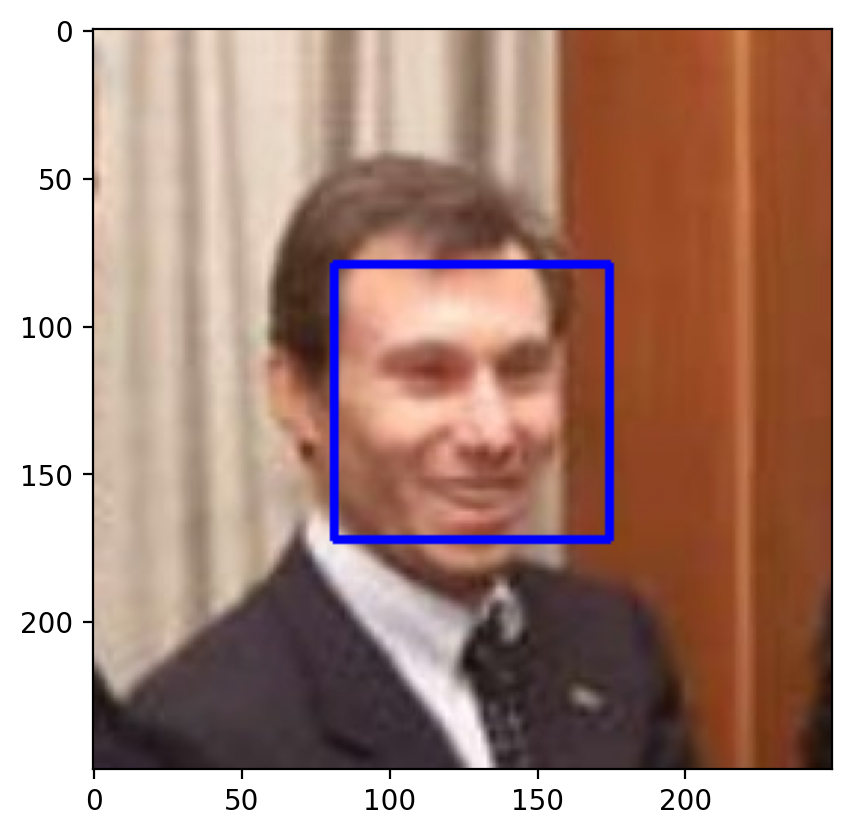

In [5]:
view_face('lfw/lfw/German_Khan/German_Khan_0001.jpg')

## We loop through the first 100 faces in the human files and the dog file to see how many faces are detected

In [6]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
count = 0
for file in human_files_short:
    i = 0
    value = view_face2(file)
    count = count + int(value)
    i = i + 1
print(f'{count}%')
# 99% means the face detector function identified 99/100 faces in the first 100 human files

99%


In [7]:
# Picture where the face was not detected
for file in human_files_short:
    if view_face2(file) != True:
        print(file)

lfw/lfw/Claudia_Pechstein/Claudia_Pechstein_0005.jpg


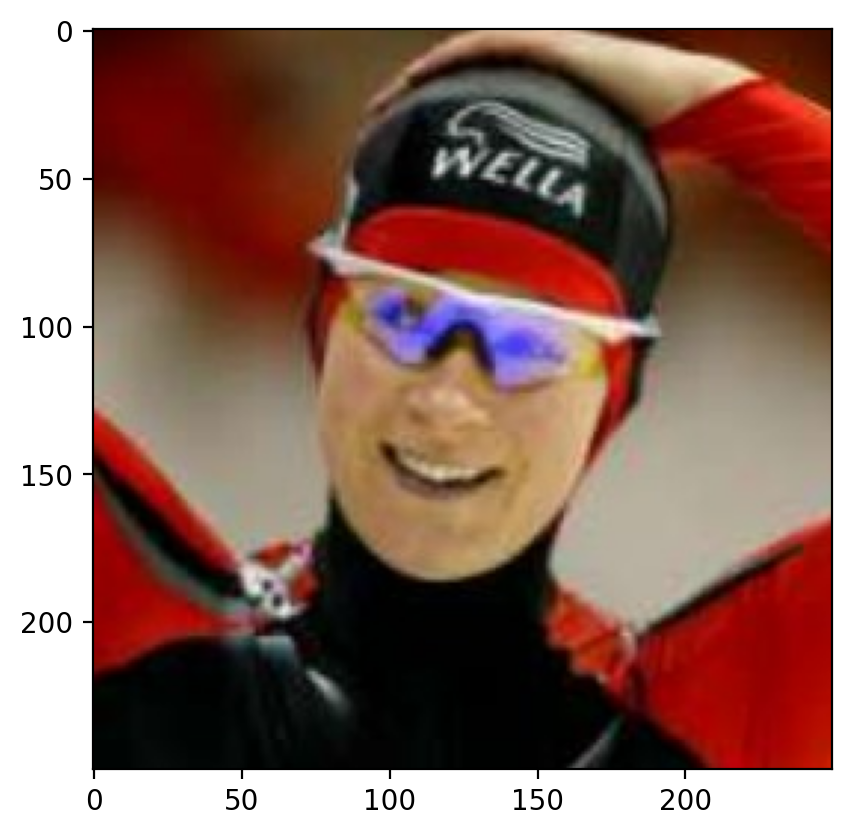

In [8]:
view_face('lfw/lfw/Claudia_Pechstein/Claudia_Pechstein_0005.jpg')

In [9]:
# Number of faces detected in the dog files
count = 0
for file in dog_files_short:
    i = 0
    value = view_face2(file)
    count = count + int(value)
    i = i + 1
print(f'{count}%')

18%


In [11]:
# So these are the files paths in which the face detector detected a face in it
dog_files_short2 = dog_files[:2]
for file in dog_files_short:
    if view_face2(file) != False:
        print(file)

dogImages/dogImages/valid/122.Pointer/Pointer_07834.jpg
dogImages/dogImages/valid/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07325.jpg
dogImages/dogImages/valid/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07309.jpg
dogImages/dogImages/valid/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07336.jpg
dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03054.jpg
dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03095.jpg
dogImages/dogImages/valid/024.Bichon_frise/Bichon_frise_01769.jpg
dogImages/dogImages/valid/024.Bichon_frise/Bichon_frise_01745.jpg
dogImages/dogImages/valid/024.Bichon_frise/Bichon_frise_01708.jpg
dogImages/dogImages/valid/024.Bichon_frise/Bichon_frise_01748.jpg
dogImages/dogImages/valid/036.Briard/Briard_02528.jpg
dogImages/dogImages/valid/036.Briard/Briard_02512.jpg
dogImages/dogImages/valid/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05156.jpg
dogImages/dogImages/valid/089.Iris

### So from the results, a conclusion can be drawn to the fact that the face detector
### performs better on detecting human faces compared to the dog faces

In [12]:
vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

In [13]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),  # Resize to the input size of VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# These are the default transformation for both the vgg16 and resnet50 model based on its documentation

In [14]:
# Loaded the VGG16 model and used it to make prediction of a dog image
def VGG_predict(img_path):
    img = Image.open(img_path)
    # The image undergoes the required transformation before input to the model
    img = transform(img)
    img = img.unsqueeze(0)
    # Set the model to evaluation mode to make predictions
    vgg16.eval()
    with torch.no_grad():
        predictions = vgg16(img)
    predicted_class_index = torch.argmax(predictions).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")
    return predicted_class_name

In [15]:
def RESNET_predict(img_path):
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    resnet50.eval()
    with torch.no_grad():
        predictions = resnet50(img)
    predicted_class_index = torch.argmax(predictions).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")
    return predicted_class_name

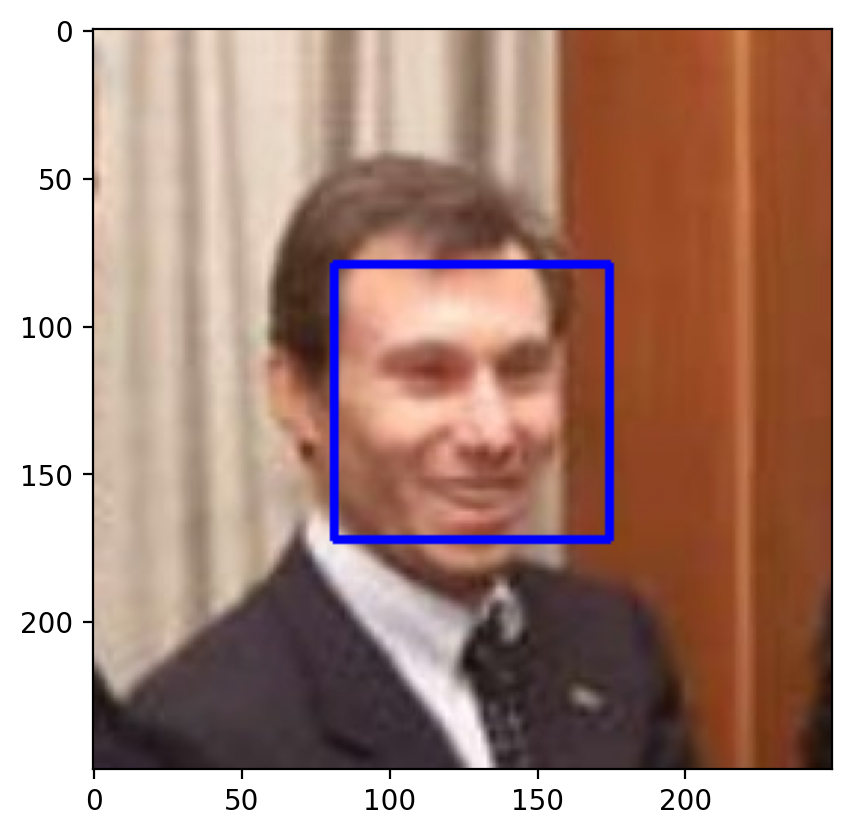

The model predicts this is a suit, suit of clothes


In [18]:
image_path = 'lfw/lfw/German_Khan/German_Khan_0001.jpg'
a = VGG_predict(image_path)
view_face(image_path)
print(f'The model predicts this is a {output}') 

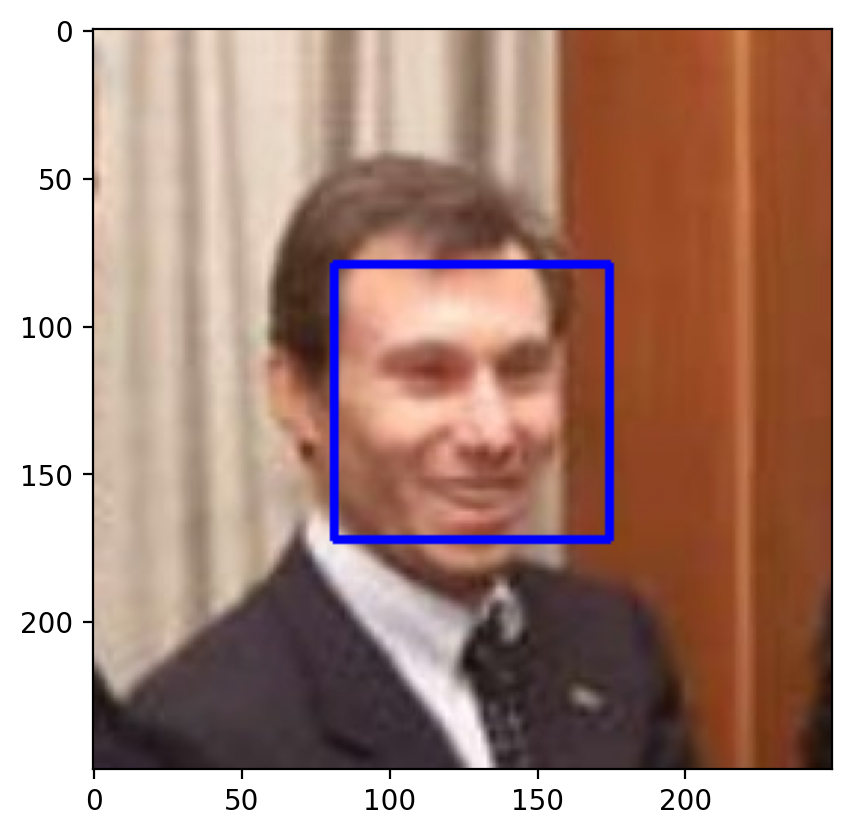

The resnet50 model predicts this is a Windsor tie


In [19]:
image_path = 'lfw/lfw/German_Khan/German_Khan_0001.jpg'
output = RESNET_predict(image_path)
view_face(image_path)
print(f'The resnet50 model predicts this is a {output}')

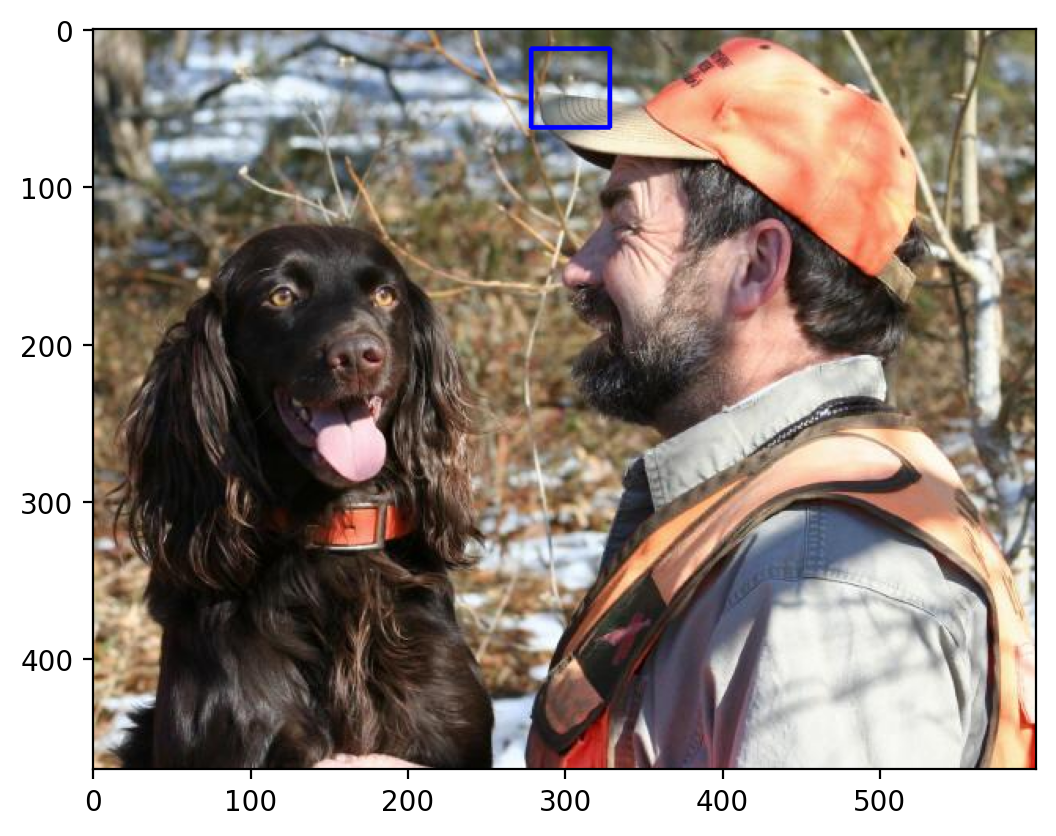

The model predicts this is a dog of breed Gordon setter


In [20]:
image_path2 = 'dogImages/dogImages/valid/035.Boykin_spaniel/Boykin_spaniel_02465.jpg'
output = VGG_predict(image_path2)
view_face(image_path2)
print(f'The vgg16 model predicts this is a dog of breed {output}')
# The breed the model identified is a very identical breed to the Sussex Spaniel

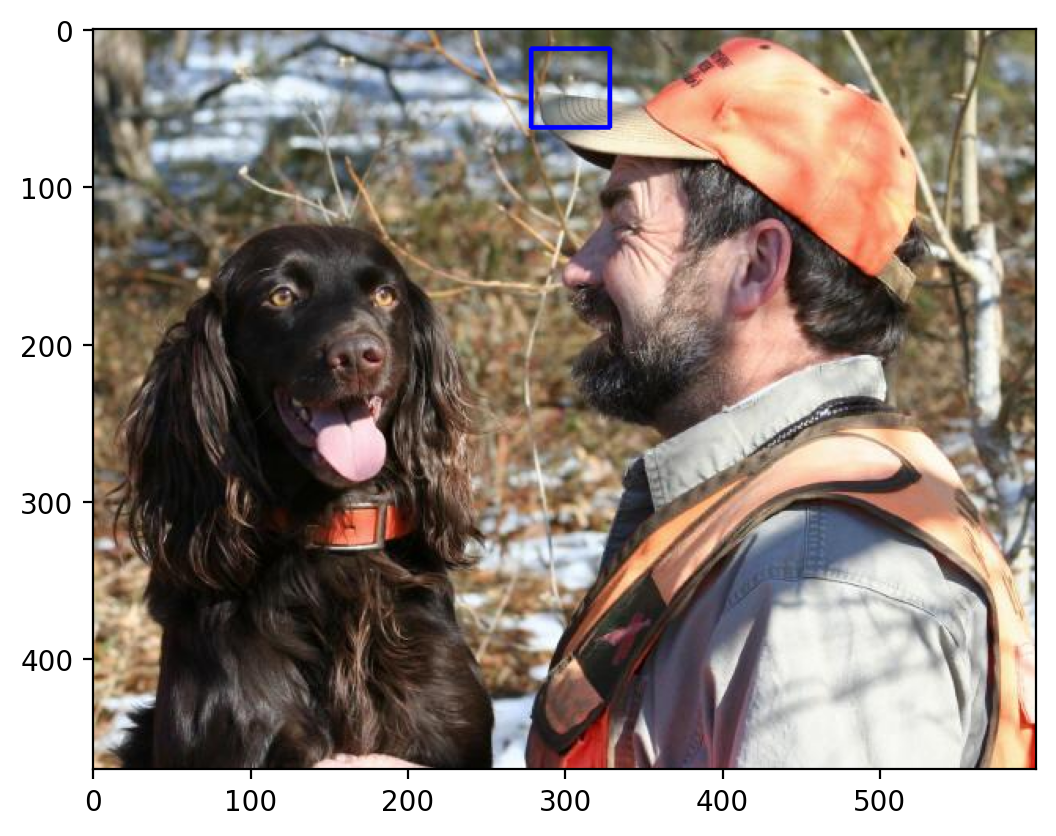

The resnet50 model predicts this is a dog of breed Sussex spaniel


In [21]:
image_path2 = 'dogImages/dogImages/valid/035.Boykin_spaniel/Boykin_spaniel_02465.jpg'
output = RESNET_predict(image_path2)
view_face(image_path2)
print(f'The resnet50 model predicts this is a dog of breed {output}')
# The Sussex Spaniel is the correct breed of the dog hence, the resnet50 model performed better on this image than the vgg16

In [22]:
# A dog detector function that returns True if a dog is in the image or False if there is no dog
# According to the 1000 outputs of the pretrained VGG model, between 151 - 268 are different breeds of dogs hence,
# If a models prediction falls between these numbers it means the model identified a dog
def is_dog(img_path):
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    vgg16.eval()
    with torch.no_grad():
        predictions = vgg16(img)
    predicted_class_index = torch.argmax(predictions).item()
    is_dog = 150 <= predicted_class_index <= 268
    return is_dog

In [23]:
# A dog detector function that returns True if a dog is in the image or False if there is no dog
# According to the 1000 outputs of the pretrained RESNET50 model, between 151 - 268 are different breeds of dogs hence,
# If a models prediction falls between these numbers it means the model identified a dog
def is_dog2(img_path):
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    resnet50.eval()
    with torch.no_grad():
        predictions = resnet50(img)
    predicted_class_index = torch.argmax(predictions).item()
    is_dog = 150 <= predicted_class_index <= 268
    return is_dog

In [24]:
is_dog('dogImages/dogImages/valid/035.Boykin_spaniel/Boykin_spaniel_02465.jpg')

True

In [25]:
is_dog2('dogImages/dogImages/valid/035.Boykin_spaniel/Boykin_spaniel_02465.jpg')

True

In [26]:
# So now we test the functions to see if it identifies a dog when it sees a human face
is_dog('lfw/lfw/German_Khan/German_Khan_0001.jpg')

False

In [27]:
is_dog2('lfw/lfw/German_Khan/German_Khan_0001.jpg')

False

In [30]:
# To check the performance of the dog detector function using the first
# 100 images in our human file and dog file and the vgg16 model
count = 0
for file in human_files_short:
    value = is_dog(file)
    count = count + int(value)
print(f'{count}%')
# So this produces a 1% accuracy which means it identified 1 dog in the 100 human faces files

1%


In [31]:
# To check the performance of the dog detector function using the first
# 100 images in our human file and dog file and the resnet50 model
count = 0
for file in human_files_short:
    value = is_dog2(file)
    count = count + int(value)
print(f'{count}%')
# This gave a 0% which means it did not identify an dog in the 100 human files which is a better accuracy than the vgg16 model

0%


In [32]:
# So we view the one and only file in the first 100 human files that the vgg16 model predicts as a dog
count = 0
for file in human_files_short:
    value = is_dog(file)
    if value == True:
        print(file)

lfw/lfw/Heidi_Fleiss/Heidi_Fleiss_0002.jpg


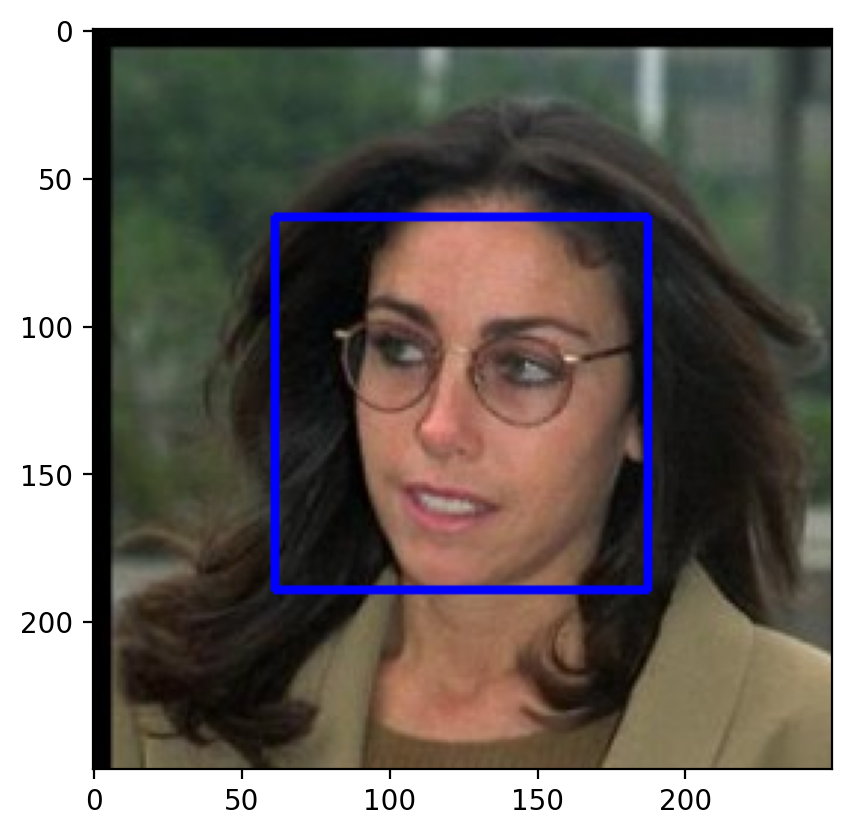

In [33]:
view_face('lfw/lfw/Heidi_Fleiss/Heidi_Fleiss_0002.jpg')

In [34]:
# Cross Checking to see if the model predicts this as a dog and it does. Oops!
is_dog('lfw/lfw/Heidi_Fleiss/Heidi_Fleiss_0002.jpg')

True

In [35]:
VGG_predict('lfw/lfw/Heidi_Fleiss/Heidi_Fleiss_0002.jpg')
# so the model predicts this image to look like a Afghan hound

'Afghan hound, Afghan'

In [36]:
count = 0
for file in dog_files_short:
    value = is_dog(file)
    count = count + int(value)
print(f'{count}%')
# So the vgg16 model predicts with a 95% accuracy of the 100 images, the presence of a dog which is relatively good.

95%


In [37]:
count = 0
for file in dog_files_short:
    value = is_dog2(file)
    count = count + int(value)
print(f'{count}%')
# So the resnet model predicts with a 96% accuracy of the 100 images, the presence of a dog which is 15 better than the vgg16 model.

96%


In [38]:
# So we view the images the vgg16 model did not predict as a dog and add them into a not_dog array so we can view them later
not_dog = []
for file in dog_files_short:
    value = is_dog(file)
    if value == False:
        not_dog.append(file)
not_dog

['dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03054.jpg',
 'dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03095.jpg',
 'dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03067.jpg',
 'dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03070.jpg',
 'dogImages/dogImages/valid/089.Irish_wolfhound/Irish_wolfhound_06067.jpg']

In [39]:
# So we view the images the vgg16 model did not predict as a dog
not_dog2 = []
for file in dog_files_short:
    value = is_dog2(file)
    if value == False:
        not_dog2.append(file)
not_dog2

['dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03051.jpg',
 'dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03095.jpg',
 'dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03067.jpg',
 'dogImages/dogImages/valid/043.Canaan_dog/Canaan_dog_03070.jpg']

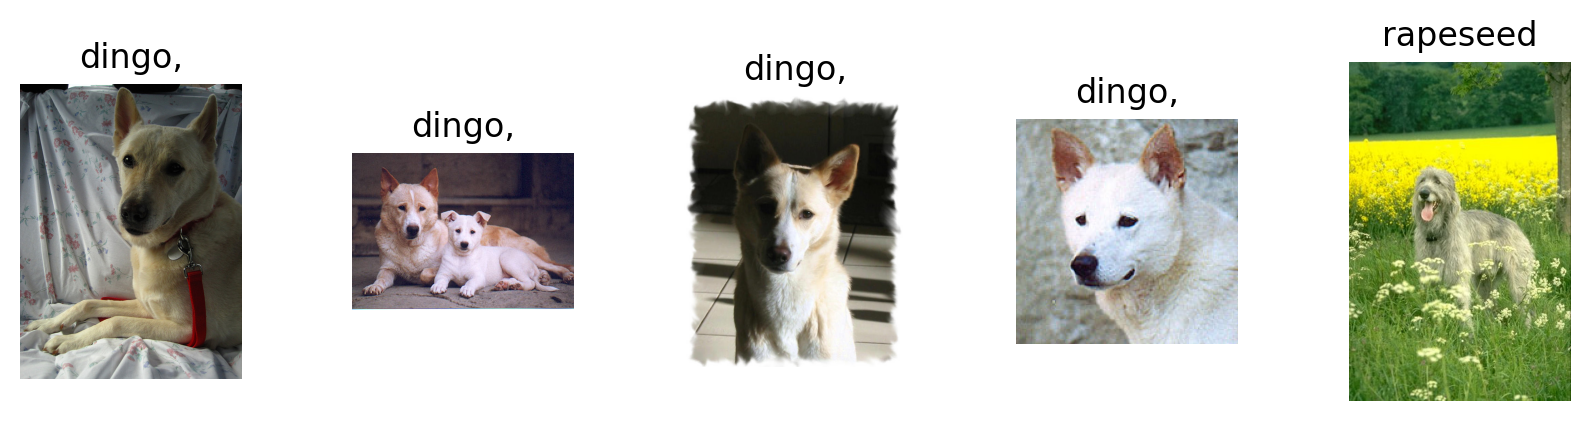

In [40]:
'''for path in not_dog:
    view_face(path)
'''
# So we view the images the vgg16 model predicted as not dog
fig, ax = plt.subplots(figsize=(10, 8), ncols=5)
for j in range(5):
    face_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(not_dog[j])
    label = VGG_predict(not_dog[j])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[j].imshow(img_rgb)
    ax[j].set_title(label.split(' ')[0])
    ax[j].axis('off')
    plt.subplots_adjust(wspace=0.5)

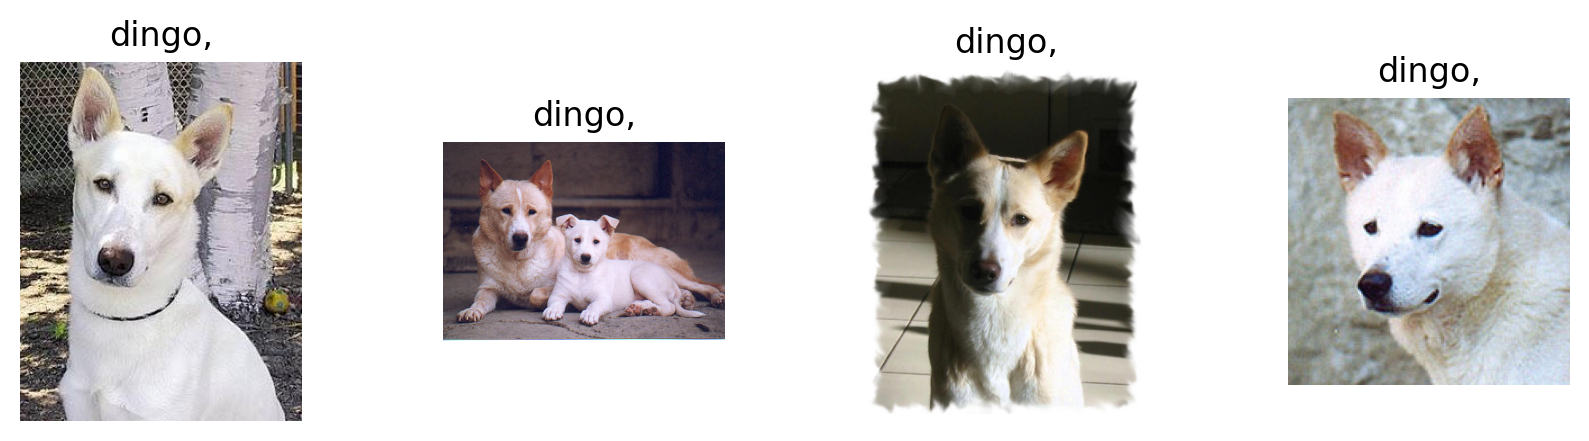

In [41]:
'''for path in not_dog:
    view_face(path)
'''
fig, ax = plt.subplots(figsize=(10, 8), ncols=4)
for j in range(4):
    face_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(not_dog2[j])
    label = RESNET_predict(not_dog2[j])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[j].imshow(img_rgb)
    ax[j].set_title(label.split(' ')[0])
    ax[j].axis('off')
    plt.subplots_adjust(wspace=0.5)

### So from these. According to the predicted values, the models intepreted the first 4 images as a breed of wolf called 'dingo' and using our bare eyes, we can understand why
### the 5th image, the vgg16 model predicted the breed of the flower around it which is 'rapeseed'

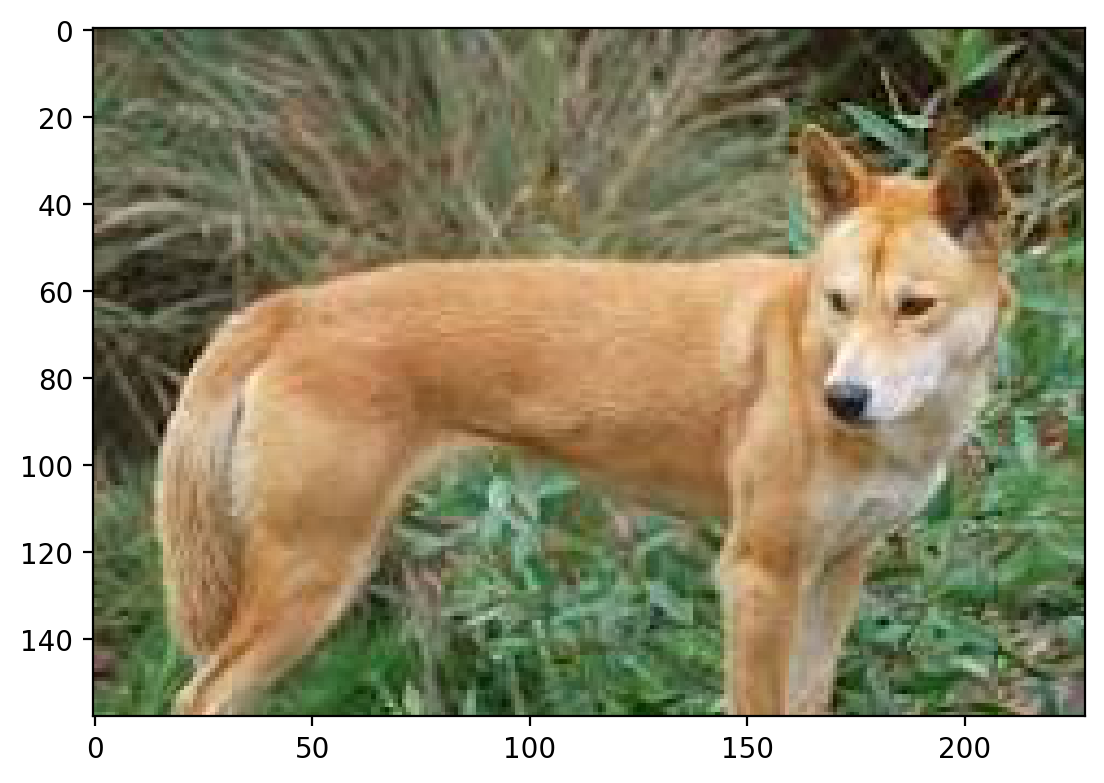

In [42]:
# Below is an Image of a Dingo
img = Image.open('dingo.jpeg')
plt.imshow(img);

## So we can draw the conclusion that the resnet50 model performed a little bit better than the vgg16 model

# Next I am going to build my own CNN layer, train and validate the model then test the model

In [43]:
# Data Augumentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),  # Resize to the input size of VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [44]:
trainset = datasets.ImageFolder('dogImages/dogImages/train', transform=train_transform)
validset = datasets.ImageFolder('dogImages/dogImages/valid', transform=train_transform)
testset = datasets.ImageFolder('dogImages/dogImages/test', transform=train_transform)

In [86]:
len(testset) 

836

In [55]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [ ]:
class_names = trainset.classes

In [48]:
# This is the Architecture of my CNN model
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 133)
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm = nn.BatchNorm1d(num_features=500)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [49]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [78]:
# This is the function that takes in parameters and trains the model
def train(model, criterion, optimizer, trainloader, validloader, epochs=20, save_path='project2.pth'):
    valid_loss_min = np.Inf
    for e in range(epochs):
        print(f"Epoch {e+1}/{epochs}")
        running_loss = 0
        validation_loss = 0
        model.train()
        for i, (images, labels) in enumerate(trainloader):
            print(f"Batch {i+1}/{len(trainloader)}")
            logps = model(images)
            loss = criterion(logps, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss = running_loss + loss.item()*images.size(0)
        model.eval()
        with torch.no_grad():
            for images, labels in validloader:
                logps = model(images)
                loss = criterion(logps, labels)
                validation_loss = validation_loss + loss.item()*images.size(0)
        running_loss = running_loss/len(trainloader.dataset)
        validation_loss = validation_loss/len(validloader.dataset)
        print(
            f'{e+1}/{epochs} gives an average training loss of {running_loss} and average validation loss of {validation_loss}'
        )
        if validation_loss <= valid_loss_min:
            print(
                f'the validation loss decreased: {valid_loss_min:.6f} --> {validation_loss:.6f}. Saving model'
            )
            torch.save(model.state_dict(), save_path)
            valid_loss_min = validation_loss
    return model

In [ ]:
train(model, criterion, optimizer, trainloader, validloader, epochs=10, save_path='project3.pth')

In [147]:
# Load the project.pth model and use it for testing
model.load_state_dict(torch.load('project3.pth'))

<All keys matched successfully>

In [66]:
# A function that tests the performance of the model
def test(model, criterion, optimizer, testloader, epochs=40):
    average_accuracy = []
    for e in range(epochs):
        testing_loss = 0
        test_correct = 0
        model.eval()
        for images, labels in testloader:
            logps = model(images)
            loss = criterion(logps, labels)
            testing_loss = testing_loss + loss.item()*images.size(0)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += torch.mean(equals.type(torch.FloatTensor)).item()
        testing_loss = testing_loss/len(testloader.dataset)
        average_accuracy.append(test_correct/len(testloader))
        print(f'{e+1}/{epochs} gives an average loss of {testing_loss}')
    print(f'the average accuracy of the model is {(np.sum(average_accuracy)/len(average_accuracy)) * 100}%')

In [148]:
test(model, criterion, optimizer, testloader, epochs=5)

1/5 gives an average loss of 3.768515352997483
2/5 gives an average loss of 3.7554409515344354
3/5 gives an average loss of 3.7530960557563455
4/5 gives an average loss of 3.758159929485412
5/5 gives an average loss of 3.745679665980727
the average accuracy of the model is 14.444444444444443%


## Creating a CNN to classifyy breed of dog using Transfer Learning 
### we would use both the Vgg16 and resnet50 models

In [137]:
# Import the VGG16 model and change the last layer to output 133 breeds of dogs
model2 = models.vgg16(weights='VGG16_Weights.DEFAULT')
# Freeze the initial layers of the model to reduce computational power when training and validating
for param in model2.features.parameters():
    param.required_grad = False
n_inputs = model2.classifier[6].in_features
# Create a new last layer
last_layer = nn.Linear(n_inputs, 133)
# replace the initial last layer with the newly created last layer
model2.classifier[6] = last_layer


In [138]:
# Import the resnet50 model
model3 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# Freeze the parameters
for param in model3.parameters():
    param.required_grad = False
# The number of inputs in the last layer of the resnet50 model
n_input = model3.fc.in_features
# Create a new last layer
last_layer = nn.Linear(n_input, 133)
# replace the initial last layer with the newly created last layer
model3.fc = last_layer


In [113]:
criterion2 = nn.CrossEntropyLoss()
vgg16_optimizer = optim.SGD(model2.classifier.parameters(), lr=0.01)
resnet50_optimizer = optim.SGD(model3.fc.parameters(), lr=0.01)

In [ ]:
model_transfer_vgg16 = train(model2, criterion2, vgg16_optimizer, trainloader, validloader, epochs=5, save_path='model_transfer_vgg.pth')

In [115]:
# After training and loading the state dict of the model
model_transfer_vgg16.load_state_dict(torch.load('model_transfer_vgg.pth'))

<All keys matched successfully>

In [116]:
# I get a Testing Accuracy of 86%
test(model_transfer_vgg16, criterion2, vgg16_optimizer, testloader, epochs=5)

1/5 gives an average loss of 0.47204883057962765
2/5 gives an average loss of 0.4790643626850758
3/5 gives an average loss of 0.4777842858476502
4/5 gives an average loss of 0.478336317402324
5/5 gives an average loss of 0.48061701699948767
the average accuracy of the model is 86.04166666666669%


In [ ]:
model_transfer_resnet50 = train(model3, criterion2, resnet50_optimizer, trainloader, validloader, epochs=10, save_path='model_transfer_resnet50.pth')

In [139]:
model_transfer_resnet50.load_state_dict(torch.load('model_transfer_resnet50.pth'))

<All keys matched successfully>

In [140]:
test(model_transfer_resnet50, criterion2, resnet50_optimizer, testloader, epochs=5)

1/5 gives an average loss of 2.3746358127685254
2/5 gives an average loss of 2.3779460950331255
3/5 gives an average loss of 2.375994038924076
4/5 gives an average loss of 2.378073242862829
5/5 gives an average loss of 2.3783134729668283
the average accuracy of the model is 73.63425925925927%


In [182]:
# A function that takes in an image path and predicts the following
# 1. If the image is a human, it says which breed of dog the human looks like
# 2. If the image is a Dog, it predicts the breed of the dog from the 133 breeds it was trained on
# N/B i would be using the model_transfer_vgg since it had a better testing accuracy
def predict_image(img_path):
    is_face = view_face2(img_path)
    img = Image.open(img_path).convert('RGB')
    input_tensor = test_transform(img)
    input_batch = input_tensor.unsqueeze(0)
    model_transfer_vgg16.eval()
    with torch.no_grad():
        predictions = model_transfer_vgg16(input_batch)
        predicted_class_index = torch.argmax(predictions).item()
        predicted_class_name = class_names[predicted_class_index]
    if is_face == True:
        print('Hello Human!')
        print('you look like a...')
    
    #plt.imshow(img);
    return predicted_class_name[4:]

Dandie_dinmont_terrier


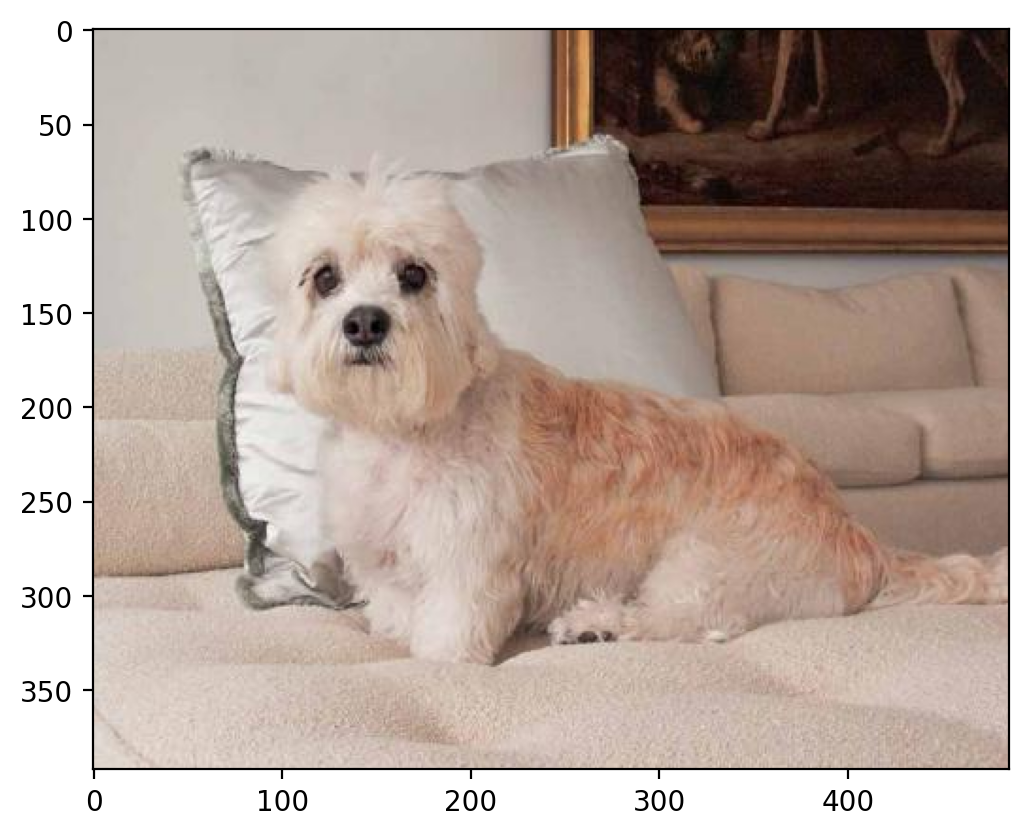

In [184]:
output = predict_image('dogImages/dogImages/test/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04138.jpg')
print(output)
view_face('dogImages/dogImages/test/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04138.jpg')

Hello Human!
you look like a...
Dachshund


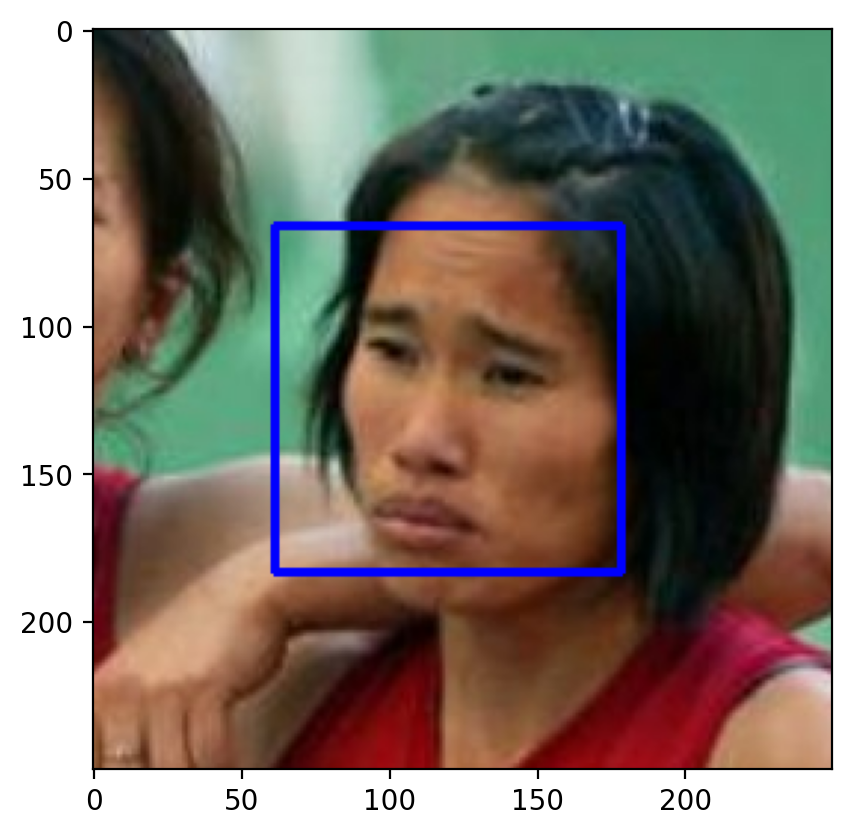

In [186]:
output = predict_image('lfw/lfw/Wang_Hailan/Wang_Hailan_0001.jpg')
print(output)
view_face('lfw/lfw/Wang_Hailan/Wang_Hailan_0001.jpg')

### Testing the model against images downloaded online

In [187]:
online_images = ['Alaskan Malamute.jpeg', 'Basset Hound.jpeg', 'poodle.jpeg']
predictions = []
for image in online_images:
    predictions.append(predict_image(image))

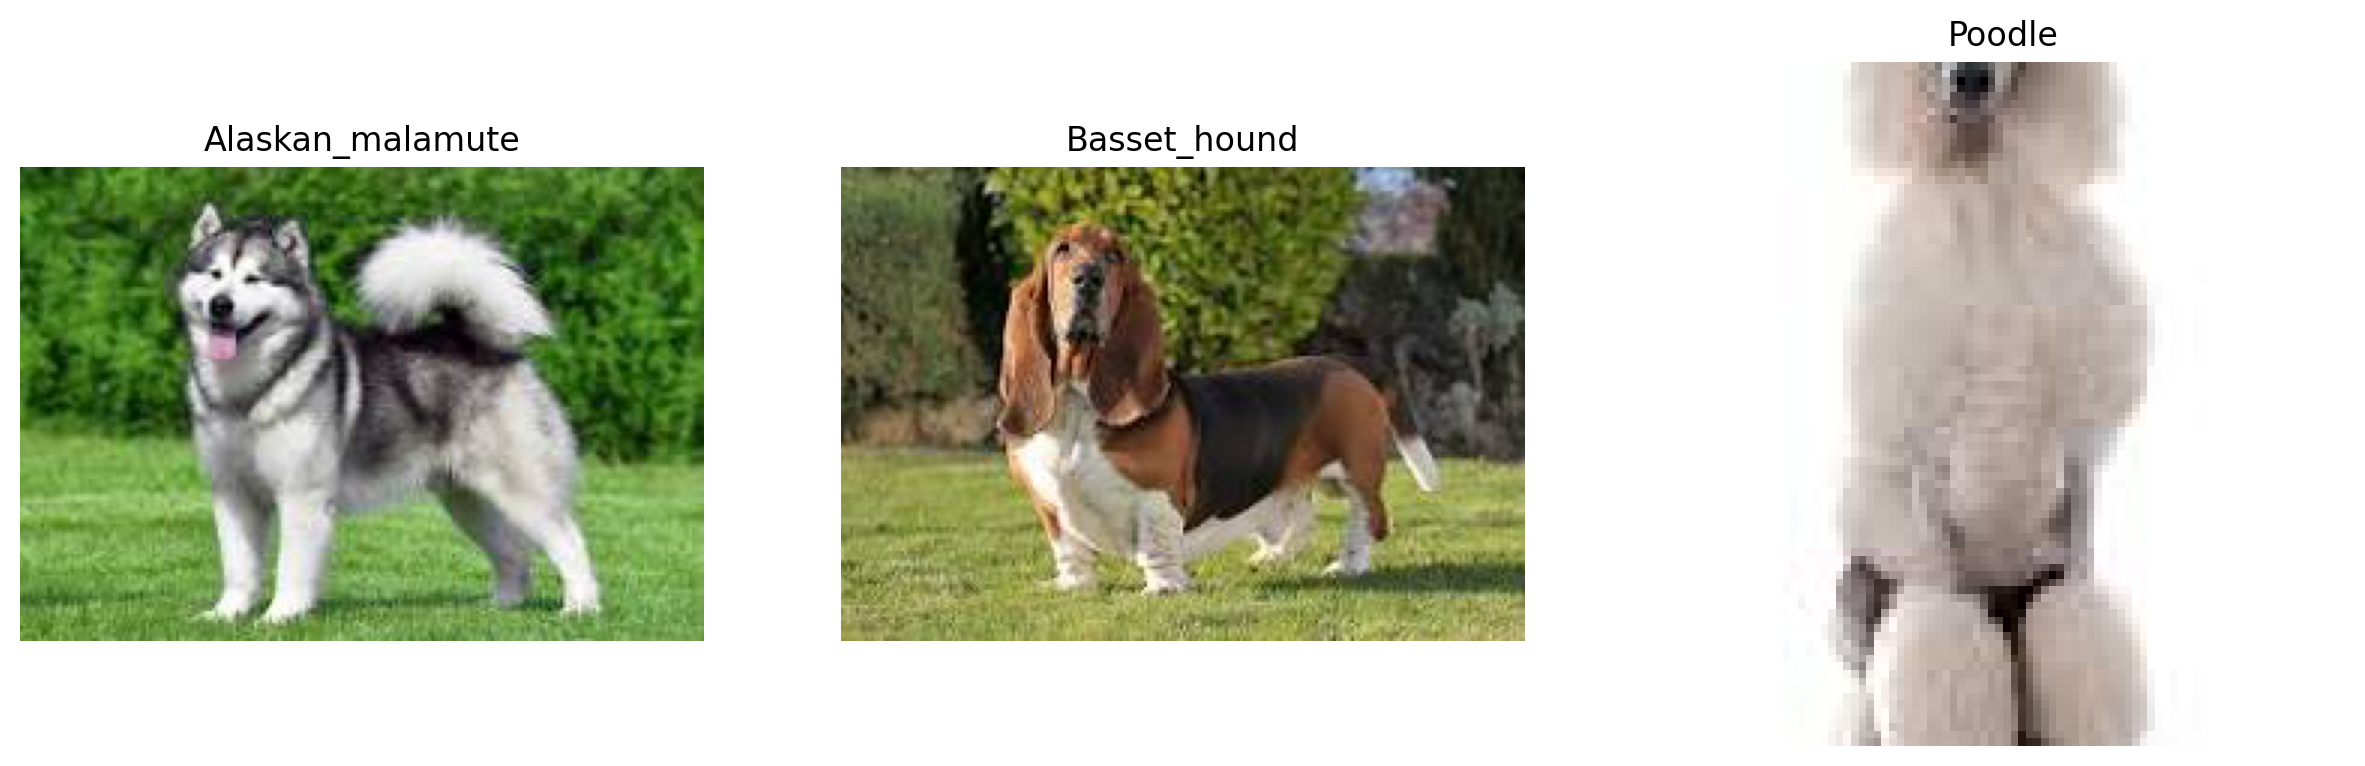

In [190]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=3)
for i in range(3):
    img = Image.open(online_images[i])
    ax[i].imshow(img)
    ax[i].set_title(predictions[i])
    ax[i].axis('off')